# Sampling from a curve

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
from mrobotics.piecewise.polyline import waypoints # our polyline "curve", not brilliant but it works
from mrobotics.motion_planning.path_timing import p0v0pfvf_selector

In [2]:
def gen_arc_points(xy_center, radius, start_radian, stop_radian, N_samples = 10):
    """generate waypoints along a circular arc

    xy_center assumed to be a Nx2 numpy array

    The waypoints will be returned ...
    *  in the same order indicated by the "start" and "stop".
    *  the first waypoint corresponds to the start of the arc
    *  the last corresponds to the end of the arc
    """
    if stop_radian - start_radian > 0.0:
        angles = np.linspace(start_radian, stop_radian, N_samples)
    else:
        angles = np.linspace(stop_radian, start_radian, N_samples)[::-1]
    xy_arc = radius * np.vstack([np.cos(angles), np.sin(angles)]).T
    return np.array(xy_center).reshape(1,2) + xy_arc

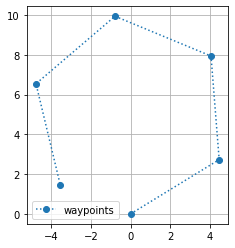

In [3]:
task_waypts = waypoints(np.array([
    *gen_arc_points([0,5.0],radius=5.0, start_radian=-np.pi/2, stop_radian=np.pi*5/4, N_samples=6)
]))
task_waypts.viz()
plt.show()

For the sack of this demo, let's neglect non-holonomic constraints, 
say the evolution of the robot XY location $p$ is given by the following straight-line motion

$$
p[k+1] = \frac{(T_\text{hor} - T_\text{replan}) p[k] +  T_\text{replan} p_\text{goal}[k]}{T_\text{hor}}
$$

In [4]:
heuristic_progress_rate = 1.0
T_hor = 2.0
T_replan = 0.5
assert T_hor > T_replan > 0.0

num_sim_steps = int(np.ceil( task_waypts.get_tot_dist()/ heuristic_progress_rate )+10)
robot_xy = np.ones((num_sim_steps+1,2))*np.nan
goal_xy  = np.ones((num_sim_steps  ,2))*np.nan

robot_xy[0] =  task_waypts.XY_waypoints[0]
path_allocation = p0v0pfvf_selector(
    path_obj=task_waypts, 
    initial_progress=task_waypts.project(XY_query=robot_xy[0], arclength_init_guess=0.0), 
    update_interval=T_replan  # for ensuring if the path progress changes abruptly, we will catch it.
)

print(f"Desired progress increment for each horizon: {T_hor*heuristic_progress_rate:.2f} m")

Desired progress increment for each horizon: 2.00 m


In [5]:
class dummy_motion_model:
    def __init__(self, T_replan, T_hor):
        T_hor = 2.0
        T_replan = 0.5
        assert T_hor > T_replan > 0.0
        time_ratio = T_replan/ T_hor
        self.b = time_ratio
        self.a = 1- time_ratio
    def __call__(self, xy_robot_current, xy_goal_current):
        return self.a*xy_robot_current + self.b*xy_goal_current

motion_model = dummy_motion_model(T_replan=T_replan, T_hor=T_hor)
# some testing
test_p_new_computed = motion_model(np.array([0,0]), np.array([5,4]) )
test_p_new_correct  = np.array([1.25, 1.00])
assert np.allclose(test_p_new_correct, test_p_new_correct)
del test_p_new_computed, test_p_new_correct


In [6]:
for i in range(num_sim_steps):
    p0, v0, pf, vf = path_allocation.update(
        [*robot_xy[i], 0.1234],
        T_horizon=T_hor, 
        desired_progress_rate=heuristic_progress_rate
    )
    goal_xy[i] = pf
    robot_xy[i+1] = motion_model(robot_xy[i], pf)
    
    # print(f"path progress: {path_allocation.progress:.2f} m: ",p0, v0, pf, vf)

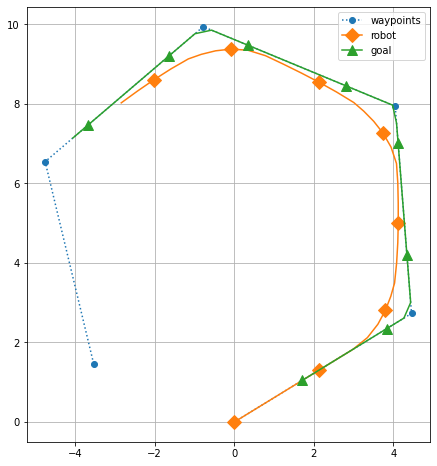

In [7]:
_, ax = plt.subplots(figsize=(8,8))
task_waypts.viz(ax=ax)
ax.plot(*robot_xy.T,label='robot',marker='D', ms=10, markevery=5)
ax.plot(*goal_xy.T,label='goal', marker='^', ms=10, markevery=5)
ax.legend()
plt.show()